<a href="https://colab.research.google.com/github/AI-comic/profile/blob/main/kaggle_70_Dog_Breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [2]:
# define paths

INPUT_DIR = '/content/drive/MyDrive/수업/2024 하이테크 학습자료_김찬수/과제/20240621_딥러닝실습_kaggle'
OUTPUT_DIR = '/content/drive/MyDrive/수업/2024 하이테크 학습자료_김찬수/과제/20240621_딥러닝실습_kaggle/working/'

TRAIN_DIR = '/content/drive/MyDrive/수업/2024 하이테크 학습자료_김찬수/과제/20240621_딥러닝실습_kaggle/train'
VAL_DIR = '/content/drive/MyDrive/수업/2024 하이테크 학습자료_김찬수/과제/20240621_딥러닝실습_kaggle/valid'
TEST_DIR = '/content/drive/MyDrive/수업/2024 하이테크 학습자료_김찬수/과제/20240621_딥러닝실습_kaggle/test'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [3]:
# generate datasets
# ImageDatagenerator to load the images in batches and perform data augmentation

data_gen = ImageDataGenerator(rescale=1/255)

In [4]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 210 images belonging to 70 classes.


In [5]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [6]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
 dense_3 (Dense)             (None, 70)                7070      
                                                                 
Total params: 22014754 (83.98 MB)
Trainable params: 211970 (828.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [13]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
# checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [14]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=20, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/20
248/248 [==============================] - 1174s 5s/step - loss: 1.0690 - accuracy: 0.7340 - val_loss: 0.6967 - val_accuracy: 0.8542 - lr: 0.0100
Epoch 2/20
248/248 [==============================] - 44s 176ms/step - loss: 0.5880 - accuracy: 0.8380 - val_loss: 0.6833 - val_accuracy: 0.8661 - lr: 0.0100
Epoch 3/20
248/248 [==============================] - 42s 171ms/step - loss: 0.4981 - accuracy: 0.8611 - val_loss: 0.7675 - val_accuracy: 0.8646 - lr: 0.0100
Epoch 4/20
248/248 [==============================] - 45s 182ms/step - loss: 0.5422 - accuracy: 0.8534 - val_loss: 0.7360 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5/20
248/248 [==============================] - 45s 180ms/step - loss: 0.5191 - accuracy: 0.8629 - val_loss: 1.0222 - val_accuracy: 0.8586 - lr: 0.0100
Epoch 6/20
248/248 [==============================] - 40s 163ms/step - loss: 0.4657 - accuracy: 0.8812 - val_loss: 0.9618 - val_accuracy: 0.9122 - lr: 0.0100
Epoch 7/20
248/248 [==============================] -

In [15]:
clear_session()

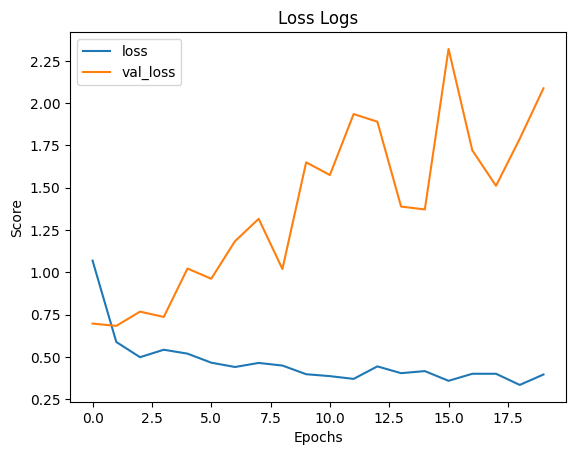

In [16]:
plt.plot(logs.history['loss'], label='loss')
plt.plot(logs.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss Logs')
plt.show()

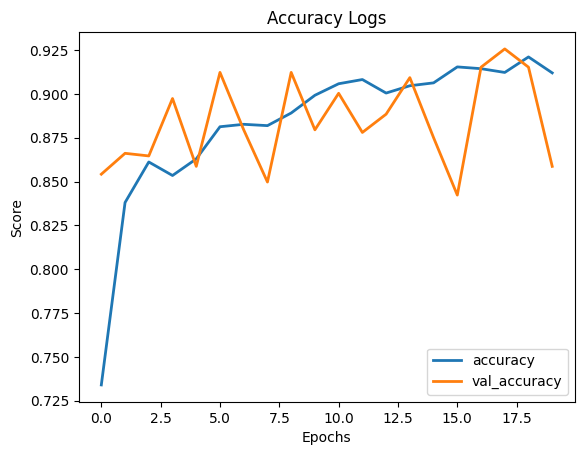

In [17]:
plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Logs')
plt.show()

In [18]:
model.evaluate(val_data)

22/22 [==============================] - 7s 290ms/step - loss: 2.2211 - accuracy: 0.8571


[2.2211239337921143, 0.8571428656578064]

In [19]:
model.evaluate(test_data)

7/7 [==============================] - 74s 12s/step - loss: 1.4133 - accuracy: 0.8000


[1.413275122642517, 0.800000011920929]

In [20]:
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

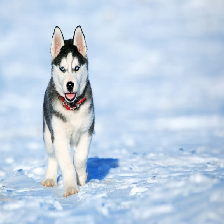

1/1 [==============================] - 0s 39ms/step
(1, 70)


('Siberian Husky', 0.99999106)

In [25]:
# requests.get(image_url, stream=True).raw
url = 'https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/4arX/image/xpew6dOelVEcYb0r68kdfJfEzLw.jpg'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob